## Mammo Crop

In [1]:
# !pip install numpy matplotlib torch torchvision opencv-python-headless segmentation-models-pytorch albumentations dicomsdl pycocotools

In [2]:
import os
from typing import List, Tuple, Dict

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import cv2
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO
import dicomsdl

This project involved adding additional segmentation labels to a small subset of images from six breast cancer classification datasets — CBIS-DDSM, CMMD, INbreast, KAU, MIAS, and VinDr. The focus was on distinguishing breast tissue from the background, aiming to remove artifacts from the images and crop them, enabling further processing with any breast cancer diagnostic model.

In [3]:
def load_image(image_path: str):
    """
    Load an image from a file using OpenCV or DICOM format.

    Parameters
    ----------
    image_path:
        The path to the image file.

    Returns
    -------
    numpy.ndarray:
        The loaded image as a NumPy array.
        If the image is in DICOM format, it is normalized with values in the range [0, 1]
        and converted to RGB and normalized.
        If the image is in a common image format (e.g., JPEG, PNG), it is loaded and
        color channels are rearranged to RGB.

    Note
    ----
    This function supports loading both standard image formats and DICOM medical
    images. For DICOM images, it assumes that the pixel data is in Hounsfield units
    and normalizes it to the [0, 1] range.
    """

    if image_path.endswith(".dcm") or image_path.endswith(".dicom"):
        dcm = dicomsdl.open(image_path)
        ptmint = dcm.PhotometricInterpretation
        image = dcm.pixelData()
        image -= image.min()
        image /= image.max()
        if ptmint == "MONOCHROME1":
            image = 1 - image
        image = np.stack((image,) * 3, axis=-1)  # convert to rgb
    else:
        image = cv2.imread(image_path).astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image /= 255.0
    return image

This cell defines a simple example of a dataset class for semantic segmentation using the COCO format. The `SemanticSegmentationDataset` class is initialized with an annotation file (`annfile`) in COCO format. It loads images and their corresponding segmentation masks, applies specified transformations, and returns the processed data. The segmentation masks are created by combining annotations into a semantic map, where each pixel is labeled with the corresponding category ID.

In [4]:
transforms = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(
            mean=[0.1426, 0.1426, 0.1426],
            std=[0.2318, 0.2318, 0.2318],
            max_pixel_value=1,
        ),
        ToTensorV2(),
    ]
)

In [5]:
class SemanticSegmentationDataset(Dataset):
    def __init__(self, root_dir, annfile, transforms=transforms):
        self.coco = COCO(annfile)
        self.transforms = transforms
        self.root_dir = root_dir
        self.ids = [img_id for img_id in sorted(self.coco.imgs.keys()) if self.coco.getAnnIds(img_id)]
        self.classes = sorted(self.coco.getCatIds())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        image_id = self.ids[index]
        image_path = os.path.join(self.root_dir, self.coco.imgs[image_id]['file_name'])
        image = load_image(image_path)
        mask = self._load_target(index)
        if self.transforms:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        return {"image": image, "mask": mask}

    def _load_image(self, path):
        return load_image(path)

    def _load_target(self, index):
        image_id = self.ids[index]
        annos = self.coco.loadAnns(self.coco.getAnnIds(image_id))
        masks = [self.coco.annToMask(anno) for anno in annos]
        labels = [anno['category_id'] for anno in annos]
        h, w = self.coco.imgs[image_id]['height'], self.coco.imgs[image_id]['width']
        return self._create_semantic_map(h, w, masks, labels)

    def _create_semantic_map(self, h, w, masks, labels):
        semantic_map = np.zeros((h, w), dtype=np.int32)
        for mask, label in zip(masks, labels):
            semantic_map[mask == 1] = label
        return semantic_map

Load the dataset and create a DataLoader to fetch batches of 8 images and masks for processing.

In [6]:
dataset = SemanticSegmentationDataset(root_dir="/home/mammography_data/input", annfile="cmmd/test.json")
dataloader = DataLoader(dataset, batch_size=8)
batch = next(iter(dataloader))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Let's create a figure with two subplots to ensure that the images and masks were loaded correctly:

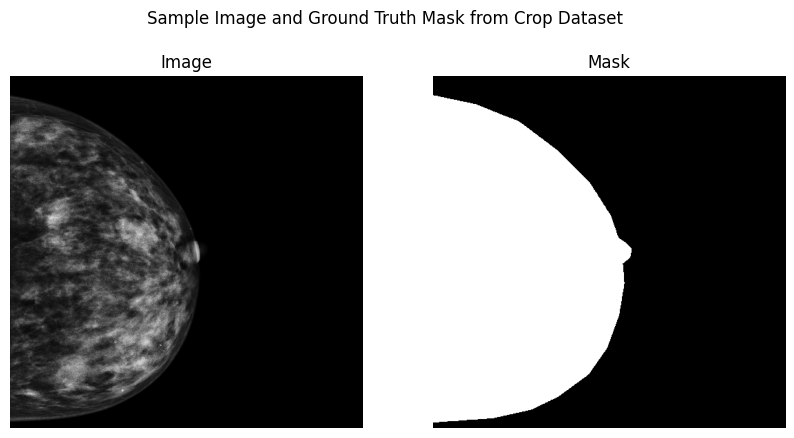

In [7]:
def minmax_normalize_image(img):
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min)


image = batch["image"][0].permute(1, 2, 0).cpu().numpy()

mask = batch["mask"][0].cpu().numpy()

image = minmax_normalize_image(image)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Sample Image and Ground Truth Mask from Crop Dataset")

axes[0].imshow(image)
axes[0].set_title("Image")
axes[0].axis("off")

axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")

plt.show()

Model declaration and loading:

In [8]:
class UNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights=None,
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self.model(inputs)

In [9]:
model = UNet()
model.load_state_dict(torch.load("epoch_100.pth"))

<All keys matched successfully>

In [10]:
model.eval()
with torch.no_grad():
    outputs = model(batch["image"])

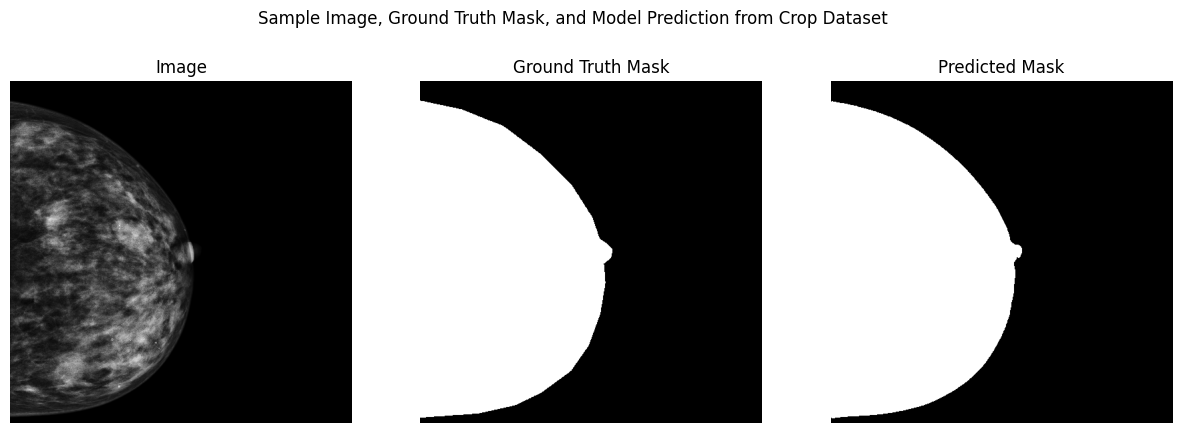

In [11]:
image = batch["image"][0].permute(1, 2, 0).cpu().numpy()
mask = batch["mask"][0].cpu().numpy()

image = minmax_normalize_image(image)
mask = minmax_normalize_image(mask)

outputs = outputs[0, 0].cpu().numpy()
pred_mask = (outputs > 0).astype(np.float32)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Sample Image, Ground Truth Mask, and Model Prediction from Crop Dataset")

axes[0].imshow(image)
axes[0].set_title("Image")
axes[0].axis("off")

axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

axes[2].imshow(pred_mask, cmap="gray")
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

plt.show()

### Example of Inference

Let's load `Mass-Test_P_01348_LEFT_MLO/10-04-2016-DDSM-NA-59725/1.000000-full mammogram images-43418/1-1.dcm` from the CBIS-DDSM dataset:

In [12]:
image = load_image("assets/1-1.dcm")
image = transforms(image=image)["image"]

In [13]:
with torch.no_grad():
    output = model(image.unsqueeze(0))[0, 0]
output = output > 0

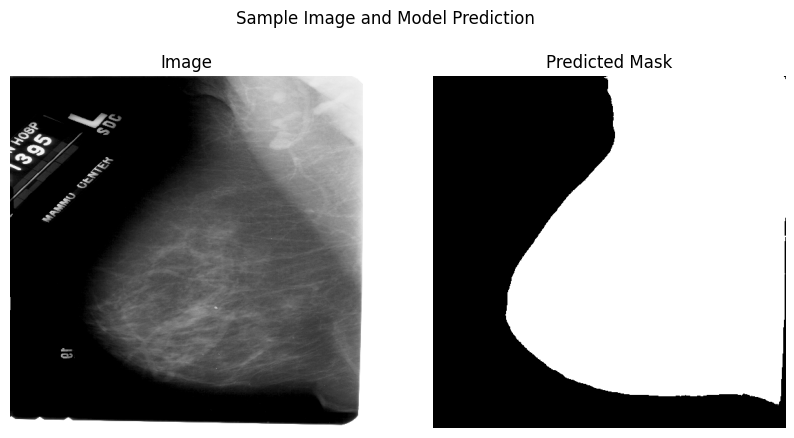

In [14]:
image = image.permute(1, 2, 0).cpu().numpy()
mask = output.cpu().numpy()

image = minmax_normalize_image(image)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Sample Image and Model Prediction")

axes[0].imshow(image)
axes[0].set_title("Image")
axes[0].axis("off")

axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Predicted Mask")
axes[1].axis("off")

plt.show()

Image cropping:

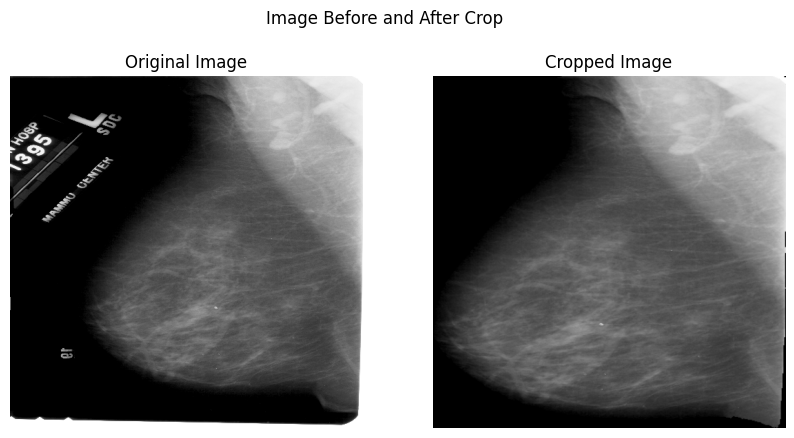

In [15]:
y, x = np.nonzero(mask)  # Get the coordinates of the non-zero mask pixels
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

crop = A.Compose(
    [A.Crop(x_min=x_min, y_min=y_min, x_max=x_max, y_max=y_max), A.Resize(512, 512)]
)  # Crop the image and the mask using the computed bounding box

image_and_mask = image * mask[:, :, np.newaxis]
transformed = crop(image=image_and_mask)

cropped_image = transformed["image"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Image Before and After Crop")

axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(cropped_image)
axes[1].set_title("Cropped Image")
axes[1].axis("off")

plt.show()